Your model will be evaluated using two metrics: profit @ top-20, and AUC. The reasons for this is to be in line with a more realistic setting. E.g. one can image data scientists in a team arguing to use AUC and optimize for that. However, as seen in the course, for this scenario, we also imagine management arguing that there is not enough budget (in terms of time and money) to contact a lot of people (or hand out a lot of promotions). Hence, they have come up with the following: based on the top-k would-be churners as predicted by your model, sum some proxy of "retained profitability" in case the customer was indeed a churner, or zero otherwise

As a proxy of profitability, the feature average cost min was deemed to be a good value. Based on the size of the test set, k=20 was deemed to be a good choice. Hence, management cares about optimizing this metric
Note that only about half of the test set is used for the "public" leaderboard. That means that the score you will see on the leaderboard is done using this part of the test only (you don't know which half). Later on through the semester, submissions are frozen and the resuls on the "hidden" part will be revealed

Also, whilst you can definitely try, the goal is not to "win", but to help you reflect on your model's results, see how others are doing, etc.

Objectives:

Some groups prefer to write their final report using Jupyter Notebook, which is fine too, as long as it is readable top-to-bottom

You can use any predictive technique/approach you want, though focus on the whole process: general setup, critical thinking, and the ability to get and validate an outcome

You're free to use unsupervised technique for your data exploration part, too. When you decide to build a black box model, including some interpretability techniques to explain it is a plus

Any other assumptions or insights are thoughts can be included as well: the idea is to take what we've seen in class, get your hands dirty and try out what we've seen

Perform a critical review of the evaluation metric chosen by management. How in line is it with AUC? What would you have picked instead? Were there particular issues with this chosen metric, in your view?

In [ ]:
# !pip install shap

In [1]:
import pandas as pd
import os
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import shap

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.inspection import permutation_importance

from sklearn.svm import SVC

import xgboost as xgb


pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [2]:
# Initialising
TRAIN_SET_FRAC = 0.8
SEED = 42
TARGET_VAR = "target"
DROP_VARS = ['Connect_Date', 'id'] # TBC
KFOLD = 5

**Loading Data**

In [3]:
# GitHib urls to fetch data from
url_train = 'https://raw.githubusercontent.com/hello-bob/AA_P1/main/data/train.csv'
url_test = 'https://raw.githubusercontent.com/hello-bob/AA_P1/main/data/test.csv'

# Read train and test data
train_data = pd.read_csv(url_train, sep = ',', skipinitialspace = True, engine = 'python')
train_data = train_data.drop(columns=DROP_VARS)
test_data  = pd.read_csv(url_test, sep = ',', skipinitialspace = True, engine = 'python')

**Data exploration**

In [4]:
train_data.head()

,Gender,Age,L_O_S,Dropped_Calls,tariff,Handset,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,Nat_call_cost_Sum,AvePeak,AveOffPeak,AveWeekend,National_calls,National mins,AveNational,All_calls_mins,Dropped_calls_ratio,Usage_Band,Mins_charge,call_cost_per_min,actual call cost,Total_call_cost,Total_Cost,Tariff_OK,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,high Dropped calls,No Usage,target
0,F,50.0,29.200000,2.0,Play 100,BS210,62.0,153.000000,185.0,438.600001,4.0,29.0,126.002615,2.045727,2.467742,2.370811,7.25,251.0,620.600001,2.472510,746.602616,0.003984,Med,20.600001,9.930712,2.045727,52.446773,112.386773,OK,0.150531,0.246536,0.706735,0.046729,0.203034,F,F,0
1,M,25.0,46.533333,1.0,CAT 100,ASAD90,146.0,718.800000,98.0,164.700000,4.0,37.2,251.580636,41.072379,4.923288,1.680612,9.30,248.0,920.700000,3.712500,1172.280636,0.002016,Med,320.700000,12.807103,41.072380,116.546571,221.546571,OK,0.188988,0.780710,0.178886,0.040404,0.273249,F,F,1
2,F,46.0,38.066667,1.0,CAT 50,WC95,160.0,322.800000,7.0,123.900000,0.0,0.0,91.584877,21.575073,2.017500,17.700000,0.00,167.0,446.700000,2.674850,538.284877,0.002994,MedLow,146.700000,12.226326,17.936021,45.411484,128.811484,OK,0.239300,0.722633,0.277367,0.000000,0.205025,F,F,0
3,F,59.0,27.400000,1.0,CAT 50,BS110,84.0,317.400001,57.0,161.699999,0.0,0.0,23.998036,20.950771,3.778571,2.836842,0.00,141.0,479.100000,3.397872,503.098036,0.003546,MedLow,179.100000,11.624922,20.820235,28.019646,111.419646,OK,0.221467,0.662492,0.337508,0.000000,0.050090,F,F,0
4,F,25.0,21.433333,1.0,Play 300,WC95,14.0,309.600000,326.0,637.800000,6.0,14.4,87.051515,0.000000,22.114286,1.956442,2.40,346.0,961.800000,2.779769,1048.851515,0.001445,Med,-838.200000,9.403618,0.000000,34.820606,112.760606,OK,0.107509,0.321896,0.663132,0.014972,0.090509,F,F,0


In [5]:
# Check data types
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5044 entries, 0 to 5043
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Gender                  5044 non-null   object 
 1   Age                     5044 non-null   float64
 2   L_O_S                   5044 non-null   float64
 3   Dropped_Calls           5044 non-null   float64
 4   tariff                  5044 non-null   object 
 5   Handset                 5044 non-null   object 
 6   Peak_calls_Sum          5044 non-null   float64
 7   Peak_mins_Sum           5044 non-null   float64
 8   OffPeak_calls_Sum       5044 non-null   float64
 9   OffPeak_mins_Sum        5044 non-null   float64
 10  Weekend_calls_Sum       5044 non-null   float64
 11  Weekend_mins_Sum        5044 non-null   float64
 12  International_mins_Sum  5044 non-null   float64
 13  Nat_call_cost_Sum       5044 non-null   float64
 14  AvePeak                 5044 non-null   

In [6]:
# Basic descriptives
train_data.describe(include='all')

,Gender,Age,L_O_S,Dropped_Calls,tariff,Handset,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,Nat_call_cost_Sum,AvePeak,AveOffPeak,AveWeekend,National_calls,National mins,AveNational,All_calls_mins,Dropped_calls_ratio,Usage_Band,Mins_charge,call_cost_per_min,actual call cost,Total_call_cost,Total_Cost,Tariff_OK,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,high Dropped calls,No Usage,target
count,5044,5044.000000,5044.000000,5044.000000,5044,5044,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5040.000000,5040,5044.000000,5040.000000,5044.000000,5044.000000,5044.000000,5044,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044,5044,5044.000000
unique,2,NaN,NaN,NaN,5,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,2,2,NaN
top,F,NaN,NaN,NaN,CAT 200,S50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Med,NaN,NaN,NaN,NaN,NaN,OK,NaN,NaN,NaN,NaN,NaN,F,F,NaN
freq,2597,NaN,NaN,NaN,2246,1175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2779,NaN,NaN,NaN,NaN,NaN,5001,NaN,NaN,NaN,NaN,NaN,4915,5040,NaN
mean,NaN,31.384417,33.626890,2.677042,NaN,NaN,239.154441,708.610393,104.080293,312.420299,16.487510,50.139360,170.310248,19.433408,8.677779,8.720703,5.758751,359.722244,1071.170052,4.117578,1241.480300,0.007445,NaN,68.572907,10.092345,19.289973,73.909497,187.082344,NaN,0.168484,0.609938,0.327813,0.061456,0.162820,NaN,NaN,0.147700
std,NaN,12.767989,14.041931,3.427875,NaN,NaN,239.627055,503.964199,97.868704,199.094991,16.379353,36.051349,142.238289,28.179154,33.860203,23.948572,9.950477,259.621742,543.766236,3.713455,636.746325,0.019773,NaN,477.166180,2.105534,28.161217,60.377401,82.471189,NaN,0.078024,0.223795,0.209852,0.063664,0.104220,NaN,NaN,0.354838
min,NaN,12.000000,9.533333,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,-1483.200000,2.000000,0.000000,0.000000,59.940000,NaN,0.048998,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000
25%,NaN,22.000000,21.266667,0.000000,NaN,NaN,59.000000,307.800001,28.000000,147.525000,4.000000,22.800000,65.511122,0.000000,1.998552,1.963418,1.882658,170.000000,665.700000,2.226314,769.666731,0.000000,NaN,-104.400001,8.578771,0.000000,32.306809,123.926851,NaN,0.134453,0.467401,0.165634,0.021097,0.079444,NaN,NaN,0.000000
50%,NaN,29.000000,33.583334,1.000000,NaN,NaN,161.000000,611.699999,73.000000,293.699999,12.000000,44.400000,132.281821,8.063094,2.915522,2.949500,2.822479,297.000000,998.099999,2.976979,1141.279249,0.002304,NaN,75.900001,9.513941,7.800333,58.122962,173.505141,NaN,0.154474,0.655549,0.286238,0.043909,0.158947,NaN,NaN,0.000000
75%,NaN,39.000000,45.866667,2.000000,NaN,NaN,343.000000,1015.950000,156.000000,447.000000,24.000000,72.000000,236.113750,29.085798,5.986867,5.779012,5.300000,484.000000,1405.650001,4.513459,1613.921676,0.006897,NaN,284.474999,11.749149,28.747465,99.011752,232.132750,NaN,0.179141,0.782501,0.459535,0.080634,0.244624,NaN,NaN,0.000000


**Data Cleaning**

In [4]:
# Impute missing data before modelling: Can quantitate and put it on the report since 4/5k samples
# Apply on the test set. Train set is ok.

train_data.isnull().any().sort_values(ascending=False) # Columns with missing values: Dropped_calls_ratio, Usage_Band, call_cost_per_min.
train_data[train_data.isnull().any(axis=1)] # 4 cases, 2 churners

imputer_compiled = ColumnTransformer(
    [("numeric_imputer", SimpleImputer(strategy="median",), ["Dropped_calls_ratio", "call_cost_per_min"]),
     ("cat_imputer", SimpleImputer(strategy="most_frequent"), ["Usage_Band"])]
)

# Imput median for numeric variables first. Because "most_frequent" strategy will impute for both numeric and categorical data
train_data[["Dropped_calls_ratio", "call_cost_per_min", "Usage_Band"]] = imputer_compiled.fit_transform(train_data)
test_data[["Dropped_calls_ratio", "call_cost_per_min", "Usage_Band"]] = imputer_compiled.transform(test_data)

# Correcting dtype
train_data[["Dropped_calls_ratio", "call_cost_per_min"]] = train_data[["Dropped_calls_ratio", "call_cost_per_min"]].astype(float)
test_data[["Dropped_calls_ratio", "call_cost_per_min"]] = test_data[["Dropped_calls_ratio", "call_cost_per_min"]].astype(float)


**Exploratory**

In [ ]:
# [For report] Pie chart about class inbalance (train set) + Percentage churn in categorical variable


In [ ]:
# [For report] correlation plot
corr = train_data.corr(numeric_only=True)

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x = corr.columns,
        y = corr.index,
        z = np.array(corr),
        text=corr.values,
        texttemplate='%{text:.2f}'
    )
)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig.show()

In [ ]:
# Print correlations which has >0.7
"""
All_calls_mins highly correlated to National minutes. It's a sum of National minutes + International mins maybe. This may indicate that
majority of calls are within nation. This corresponds to how Nat_call_cost_Sum is highly correlated to actual call cost. Not sure what's the
diff betwen actuall call cost and total call cost. Nat_call_cost_Sum could be an adjustment of actual call cost, correlation 0.999.

Total_call_cost most strongly correlated with International_mins_Sum and Total_Cost. This may suggest that costs are largely driven by 
international calls

Not sure what total calls indicate, maybe it's cost from other telco-related services e.g. broadband, cable tv etc.

Peak_mins_Sum highly correlated with all_calls_mins and national mins. This may make sense since the more minutes of calling, the higher
likelihood of calling during the peak period?

"""
corr_long = train_data.corr(numeric_only=True).melt(ignore_index=False).reset_index(drop=False)
corr_long = corr_long[(corr_long['index'] != corr_long['variable']) & (abs(corr_long['value']) >0.7)]
corr_long.sort_values(by=['index', 'variable'], ascending=True)

In [ ]:
(round((train_data['International_mins_Sum'] + train_data['National mins']),2) == round(train_data['All_calls_mins'], 2)).sum() #almost all
train_data[['All_calls_mins', 'National mins']]

In [ ]:
train_data.select_dtypes('object').columns.to_list()

In [ ]:
# [For report] Correlation between categorical variables, using cramer's V
# Generally, 
from scipy.stats.contingency import association

cat_corr_cols = train_data.select_dtypes('object').columns.to_list()
while len(cat_corr_cols) > 0:
    col = cat_corr_cols.pop(0)
    print(f'Correlation for {col}')
    for other_col in cat_corr_cols:
        contingency_tbl = pd.crosstab(train_data[col], train_data[other_col])
        cramer_V = association(contingency_tbl, method="cramer")
        print(f'Association with {other_col}: {cramer_V}')
    print('\n')
    


In [ ]:
pd.crosstab(train_data['tariff'], train_data['Usage_Band'])
pd.crosstab(train_data['Gender'], train_data['Handset'])
pd.crosstab(train_data['high Dropped calls'], train_data['Handset'])

In [ ]:
# On the metric by management
train_data.sort_values(by='average cost min', ascending=False).head(20)

In [ ]:
# Identifying outliers via isolation forest
from sklearn.ensemble import IsolationForest

outlier_df = (train_data.select_dtypes(include='number')
              .drop(columns=TARGET_VAR)
              .dropna()
              .copy())

iso_forest = IsolationForest(random_state=SEED, n_jobs=-1, contamination=0.05).fit(outlier_df)

In [ ]:
outlier_df['outlier_score'] = iso_forest.decision_function(outlier_df) # more negative indicates higher outlier-ness

In [ ]:
# https://stats.stackexchange.com/questions/404017/how-to-get-top-features-that-contribute-to-anomalies-in-isolation-forest
"""
Outstanding variables contributing to outlier (to the left of 0 on x axis) are AveOffPeak, average cost min, AveWeekend, AveNational and 
Dropped_calls_ratio. These tend to indicate the higher the values, the more of an outlier they are.
"""

# Create shap values and plot them
shap_values = shap.TreeExplainer(iso_forest).shap_values(outlier_df)
shap.summary_plot(shap_values, outlier_df, plot_type='violin')

In [ ]:
# Average shap per variable Top few: Weekend_calls_sum, nat_call_cost_sum, dropped_calls, average cost min
# a global measure of feature importance (https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)
# These values seem low to the values I saw online. 
explainer = shap.Explainer(iso_forest, outlier_df)
shap_values = explainer(outlier_df)
shap.plots.bar(shap_values)

In [ ]:
# 3 of the top 10 outliers are churners. No discernible pattern between churn and non-churn. Propose to keep all and compare 
# between models which are robust against outliers, and those not.
outlier_df[TARGET_VAR] = train_data[TARGET_VAR].copy()
outlier_df.sort_values(by='outlier_score', ascending=True).head(10).sort_values(by='target')
outlier_df.groupby('target').mean()

**Modelling**

In [6]:
X = train_data.drop(columns=TARGET_VAR)
y = train_data[TARGET_VAR] 

NUM_VARS = train_data.select_dtypes(include='number').drop(columns=TARGET_VAR).columns
CAT_VARS = train_data.select_dtypes(include='object').columns

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=1/KFOLD, stratify=y, random_state=SEED)

In [10]:
print(NUM_VARS)
print(CAT_VARS)

Index(['Age', 'L_O_S', 'Dropped_Calls', 'Peak_calls_Sum', 'Peak_mins_Sum',
       'OffPeak_calls_Sum', 'OffPeak_mins_Sum', 'Weekend_calls_Sum',
       'Weekend_mins_Sum', 'International_mins_Sum', 'Nat_call_cost_Sum',
       'AvePeak', 'AveOffPeak', 'AveWeekend', 'National_calls',
       'National mins', 'AveNational', 'All_calls_mins', 'Dropped_calls_ratio',
       'Mins_charge', 'call_cost_per_min', 'actual call cost',
       'Total_call_cost', 'Total_Cost', 'average cost min', 'Peak ratio',
       'OffPeak ratio', 'Weekend ratio', 'Nat-InterNat Ratio'],
      dtype='object')
Index(['Gender', 'tariff', 'Handset', 'Usage_Band', 'Tariff_OK',
       'high Dropped calls', 'No Usage'],
      dtype='object')


In [ ]:
# Define preprocessors for numerical and categorical features
numerical_preprocessor = Pipeline([
    ("scaler", MinMaxScaler(clip=True))
])

categorical_preprocessor = Pipeline([
    ("onehot", OneHotEncoder(drop="if_binary"))
])

In [ ]:
# Combine preprocessors and model
model = Pipeline([
    ("preprocessor", ColumnTransformer([
        ("numerical", numerical_preprocessor, NUM_VARS),
        ("categorical", categorical_preprocessor, CAT_VARS)
    ])),
    ("model", SVC(probability=True, random_state=SEED, max_iter=25000))
])
model

In [ ]:
%%time
# For SVM

parameters = {'model__kernel':['linear', 'rbf', 'sigmoid'], 
              'model__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 
              'model__gamma':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'model__class_weight':[None, 'balanced']} # rmb to add the double underscores to allow gridsearch to fit on pipelines
svc_gs_est = GridSearchCV(estimator=model, param_grid=parameters,cv=KFOLD,
                      scoring="roc_auc",n_jobs=-1, refit=True, verbose=10)
svc_gs_est.fit(X_train, y_train)

print("Done")

In [ ]:
svc_gs_results = pd.DataFrame(data=svc_gs_est.cv_results_)
svc_gs_results.sort_values(by='rank_test_score', ascending = True).to_csv('output/svc_gridsearchcv_minmaxScaler.csv')
svc_gs_results.sort_values(by='rank_test_score', ascending = True)

In [ ]:
# Best params
svc_gs_est.best_params_

In [ ]:
# Test on test set
"""
Goes up fast, but then struggles to improve TPR without increasing FPR
"""
predicted_probabilities = svc_gs_est.predict_proba(X_test)
auc_score = roc_auc_score(y_test, predicted_probabilities[:, 1])
print(f"AUC Score: {round(auc_score, 3)}") # 0.9265646948649914

RocCurveDisplay.from_estimator(svc_gs_est, X_test, y_test)

In [ ]:
# Feature importance: To note, some numerical variables share permutation importance due to high correlation
# Handset, international mins sum and usage band is at the top. As above:

"""
All_calls_mins highly correlated to National minutes. It's a sum of National minutes + International mins maybe. [International and all call mins quite impt]
Nat_call_cost_Sum could be an adjustment of actual call cost, correlation 0.999. [Actual call cost much more important than nat call cost]
Total_call_cost most strongly correlated with International_mins_Sum and Total_Cost [all 3 relatively impt]
Peak_mins_Sum highly correlated with all_calls_mins and national mins [these 3 all low feature importance]

"""
perm_importance = permutation_importance(svc_gs_est, X_test, y_test)

features = svc_gs_est.feature_names_in_

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [ ]:
# Plotting predicted probabilities against metric avg cost min
# 50% seems to be a clean cut-off
plt.scatter(y=predicted_probabilities[:, 1], x=X_test['average cost min'], alpha=0.6, )
plt.xlabel("average cost min")
plt.ylabel("pred probability")

In [ ]:
# Plotting residuals against metric avg cost min
# Most individuals where the algorithm predicts within a limit of +/-0.5 do not have high average cost per minute.
# The high value customers were "false positives" in a sense, if we were to use a decision boundary of 0.5.
plt.scatter(y=(y_test-predicted_probabilities[:, 1]), x=X_test['average cost min'], alpha=0.6)
plt.xlabel("average cost min")
plt.ylabel("residuals")

In [ ]:
# Using 25% as threshold 
pd.crosstab((predicted_probabilities[:, 1]>=0.25).astype(int), y_test)

In [ ]:
# Retrain best model on all train data: Set up the params accordingly
numerical_preprocessor = Pipeline([
    ("scaler", MinMaxScaler())
])

categorical_preprocessor = Pipeline([
    ("onehot", OneHotEncoder(drop="if_binary"))
])

best_svc_model = Pipeline([
    ("preprocessor", ColumnTransformer([
        ("numerical", numerical_preprocessor, NUM_VARS),
        ("categorical", categorical_preprocessor, CAT_VARS)
    ])),
    ("model", SVC(probability=True, random_state=SEED, C=1000, gamma=0.001, class_weight='balanced', kernel="rbf"))
])

best_svc_model.fit(X, y)

In [ ]:
# For submission
test_data_sub = pd.DataFrame(data={'ID':test_data['id'], 
                                   'PRED':best_svc_model.predict_proba(test_data)[:,1]})
test_data_sub.to_csv('output/svc_submission.csv', header=True, index=False)

In [ ]:
# For submission: Adjust for those cases with high average cost min
test_data_sub_adjusted = pd.DataFrame(data={'ID':test_data['id'], 
                                   'PRED':best_svc_model.predict_proba(test_data)[:,1],
                                           'average cost min':test_data['average cost min']})
test_data_sub_adjusted.plot(y="PRED", x="average cost min", kind="scatter")
test_data_sub_adjusted['quantile'] = (pd.qcut(test_data_sub_adjusted["average cost min"].values, 10,labels=False) + 1) / 10
test_data_sub_adjusted['PRED'] = test_data_sub_adjusted['PRED'] * test_data_sub_adjusted['quantile']
test_data_sub_adjusted['PRED'].describe()
test_data_sub.to_csv('output/svc_submission_adjusted1.csv', header=True, index=False)

In [ ]:
# For submission: use prediction threshold of 25%.  
test_data_sub_hardadjusted = pd.DataFrame(data={'ID':test_data['id'], 
                                   'PRED':best_svc_model.predict_proba(test_data)[:,1]})
test_data_sub_hardadjusted['PRED'] = (test_data_sub_hardadjusted['PRED'] >=0.25).astype(int)
test_data_sub_hardadjusted.to_csv('output/svc_submission_hardadjusted.csv', header=True, index=False)

In [ ]:
# For submission: use prediction threshold of 25%. Sort values by average cost min 
test_data_sub_hardadjusted_sorted = pd.DataFrame(data={'ID':test_data['id'], 
                                   'PRED':best_svc_model.predict_proba(test_data)[:,1],
                                           'average cost min':test_data['average cost min']})
test_data_sub_hardadjusted_sorted['PRED'] = (test_data_sub_hardadjusted_sorted['PRED'] >=0.25).astype(int)
test_data_sub_hardadjusted_sorted = test_data_sub_hardadjusted_sorted.sort_values(by=['PRED', 'average cost min'], ascending=False)
test_data_sub_hardadjusted_sorted = test_data_sub_hardadjusted_sorted.drop(columns=['average cost min'])
test_data_sub_hardadjusted_sorted.to_csv('output/svc_submission_hardadjusted_sorted.csv', header=True, index=False)

In [ ]:
# For submission: use prediction threshold of 25% + adjust for cases with high average cosst min. 
test_data_sub_adjusted2 = pd.DataFrame(data={'ID':test_data['id'], 
                                   'PRED':best_svc_model.predict_proba(test_data)[:,1],
                                           'average cost min':test_data['average cost min']})
test_data_sub_adjusted2['PRED'] = (test_data_sub_adjusted2['PRED'] >=0.25).astype(int)
test_data_sub_adjusted2['quantile'] = (pd.qcut(test_data_sub_adjusted2["average cost min"].values, 10,labels=False) + 1) / 10
test_data_sub_adjusted2['PRED'] = test_data_sub_adjusted2['PRED'] * test_data_sub_adjusted2['quantile'] 

test_data_sub_adjusted2.plot(x="quantile", y="PRED", kind="scatter")
test_data_sub_adjusted2 = test_data_sub_adjusted2.drop(columns=['quantile', 'average cost min'])
test_data_sub_adjusted2.to_csv('output/svc_submission_adjusted2.csv', header=True, index=False)

**XGBoost**

In [24]:
# Basic preprocessing
numeric_transformer = Pipeline(
    steps = [
        ("imputer", SimpleImputer(strategy="median"))
    ]
)

categorical_transformer = Pipeline(
    steps = [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUM_VARS),
        ("cat", categorical_transformer, CAT_VARS)
    ]
)

X_preprocessed = preprocessor.fit_transform(X)
# Alternatively split train-test before, do preprocessing on training data (fit_transform) then transform test data


In [25]:
X_train, X_test, y_train, y_test= train_test_split(X_preprocessed, y, test_size=0.2, stratify=y, random_state=420)

Grid search

In [ ]:
# Calcualte class ratio. Will be used to assess class imbalance during training
ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]

In [ ]:
# First do a random search over a large hyperparameter space, trying 1000 random models 
gbm_param_grid_large = {  'n_estimators': np.arange(5, 101, 1)
                        , 'max_depth': range(2, 13)
                        , 'learning_rate': np.arange(0.001, 5, 0.01)
                        , 'subsample': [0.2, 0.4, 0.6, 0.8, 1]
                        , 'colsample_bytree': [0.2, 0.5, 0.8, 1]
                        , 'reg_lambda': [0, 1, 5, 10, 100]
                        }

gbm = xgb.XGBClassifier(random_state=420, scale_pos_weight=ratio)
randomized_auc = RandomizedSearchCV(  estimator=gbm
                                    , param_distributions=gbm_param_grid_large
                                    , n_iter=1000
                                    , scoring='roc_auc'
                                    , cv=5
                                    , n_jobs=-1
                                    , verbose=1
                                    , random_state=420)

# See how the cross-validation performed (on the "training" data) and the best tuned hyperparameter values
randomized_auc.fit(X_train, y_train)
print("Best parameters found: ",randomized_auc.best_params_)
print("Lowest AUC found: ", randomized_auc.best_score_)

In [ ]:
# Now do another random search over a smaller hyperparameter space around the preivously found "best" values
gbm_param_grid_medium = {  'n_estimators': np.arange(50, 120, 1)
                         , 'max_depth': range(6, 15)
                         , 'learning_rate': np.arange(0.001, 5, 0.01)
                         , 'subsample': [0.6, 0.8, 1]
                         , 'colsample_bytree': [0.8, 1]
                         , 'reg_lambda': [0, 1, 2, 5]
                         }

gbm = xgb.XGBClassifier(random_state=420, scale_pos_weight=ratio)
randomized_auc = RandomizedSearchCV(  estimator=gbm
                                    , param_distributions=gbm_param_grid_medium
                                    , n_iter=1000
                                    , scoring='roc_auc'
                                    , cv=5
                                    , n_jobs=-1
                                    , verbose=1
                                    , random_state=420)

# See how the cross-validation performed (on the "training" data) and the best tuned hyperparameter values
randomized_auc.fit(X_train, y_train)
print("Best parameters found: ",randomized_auc.best_params_)
print("Lowest AUC found: ", randomized_auc.best_score_)

In [ ]:
# We got quite different reults, but different hyperparameter combinations can give similar results.
# Finally a grid-search that is not random around the previous "best" values.
gbm_param_grid = {  'n_estimators': [70, 80, 100, 120]
                  , 'max_depth': [8, 10, 12]
                  , 'learning_rate': [0.05, 0.1, 0.15, 0.2]
                  , 'subsample': [0.8, 1]
                  , 'colsample_bytree': [0.8, 1]
                  , 'reg_lambda': [0, 1, 2]
                  }

gbm = xgb.XGBClassifier(random_state=420, scale_pos_weight=ratio)
grid_auc = GridSearchCV(  estimator=gbm
                        , param_grid=gbm_param_grid
                        , scoring='roc_auc'
                        , cv=5
                        , n_jobs=-1
                        , verbose=1
                        )

# See how the cross-validation performed (on the "training" data) and the best tuned hyperparameter values
grid_auc.fit(X_train, y_train)
print("Best parameters found: ", grid_auc.best_params_)
print("Lowest AUC found: ", grid_auc.best_score_)

In [ ]:
# Save an output based on the previous (last) grid search
pd.DataFrame(grid_auc.cv_results_).sort_values(by='rank_test_score', ascending = True).to_csv('output/xgb_gridsearch.csv')

In [ ]:
# Get an idea about how the model performs on the test set
# Test AUC is close to the "best" model AUC on the cross-validated training set which is a good indication of not suffering from overfitting
predicted_probabilities = grid_auc.predict_proba(X_test)
auc_score = roc_auc_score(y_test, predicted_probabilities[:, 1])
auc_score

In [ ]:
# Re-train the tuned model on the entire training data (not just on the 80% of it)
best_model_xgb = Pipeline([
    ("preprocessor", ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, NUM_VARS),
            ("cat", categorical_transformer, CAT_VARS)
            ]
    )),
    ("xgboost model", grid_auc.best_estimator_)
])


best_model_xgb.fit(X, y)
pred_xgb = pd.DataFrame(best_model_xgb.predict_proba(test_data), columns=["0", "1"])

# Creating data for submission
test_data_sub = pd.DataFrame(data={'ID':test_data['id'], 
                                   'PRED':pred_xgb["1"]})
test_data_sub

In [ ]:
# Exporting results
test_data_sub.to_csv('output/xgboost_pred_submission_v2.csv', header=True, index=False)

Test - sample weights based on average cost min (?)

In [ ]:
# First do a random search over a large hyperparameter space, trying 1000 random models 
gbm_param_grid_large = {  'n_estimators': np.arange(5, 101, 1)
                        , 'max_depth': range(2, 13)
                        , 'learning_rate': np.arange(0.001, 5, 0.01)
                        , 'subsample': [0.2, 0.4, 0.6, 0.8, 1]
                        , 'colsample_bytree': [0.2, 0.5, 0.8, 1]
                        , 'reg_lambda': [0, 1, 5, 10, 100]
                        }

gbm = xgb.XGBClassifier(random_state=420, scale_pos_weight=ratio)
randomized_auc = RandomizedSearchCV(  estimator=gbm
                                    , param_distributions=gbm_param_grid_large
                                    , n_iter=1000
                                    , scoring='roc_auc'
                                    , cv=5
                                    , n_jobs=-1
                                    , verbose=1
                                    , random_state=420)

# See how the cross-validation performed (on the "training" data) and the best tuned hyperparameter values
randomized_auc.fit(X_train, y_train, sample_weight=X_train[:,24])
print("Best parameters found: ",randomized_auc.best_params_)
print("Lowest AUC found: ", randomized_auc.best_score_)

In [ ]:
# Now do another random search over a smaller hyperparameter space around the preivously found "best" values
gbm_param_grid_large = {  'n_estimators': np.arange(20, 60, 1)
                        , 'max_depth': range(5, 11)
                        , 'learning_rate': np.arange(0.05, 5.05, 0.05)
                        , 'subsample': [0.6, 0.8, 1]
                        , 'colsample_bytree': [0.6, 0.8, 1]
                        , 'reg_lambda': [0, 1, 5, 10]
                        }

gbm = xgb.XGBClassifier(random_state=420, scale_pos_weight=ratio)
randomized_auc = RandomizedSearchCV(  estimator=gbm
                                    , param_distributions=gbm_param_grid_large
                                    , n_iter=1000
                                    , scoring='roc_auc'
                                    , cv=5
                                    , n_jobs=-1
                                    , verbose=1
                                    , random_state=420)

# See how the cross-validation performed (on the "training" data) and the best tuned hyperparameter values
randomized_auc.fit(X_train, y_train, sample_weight=X_train[:,24])
print("Best parameters found: ",randomized_auc.best_params_)
print("Lowest AUC found: ", randomized_auc.best_score_)

In [ ]:
# Finally a grid-search that is not random around the previous "best" values.
gbm_param_grid = {  'n_estimators': [30, 50, 100]
                  , 'max_depth': [8, 10, 12]
                  , 'learning_rate': [0.01, 0.05, 0.1, 0.2]
                  , 'subsample': [0.8, 1]
                  , 'colsample_bytree': [0.8, 1]
                  , 'reg_lambda': [0, 1, 2]
                  }

gbm = xgb.XGBClassifier(random_state=420, scale_pos_weight=ratio)
grid_auc = GridSearchCV(  estimator=gbm
                        , param_grid=gbm_param_grid
                        , scoring='roc_auc'
                        , cv=5
                        , n_jobs=-1
                        , verbose=1
                        )

# See how the cross-validation performed (on the "training" data) and the best tuned hyperparameter values
grid_auc.fit(X_train, y_train, sample_weight=X_train[:,24])
print("Best parameters found: ", grid_auc.best_params_)
print("Lowest AUC found: ", grid_auc.best_score_)

In [ ]:
# Save an output based on the previous (last) grid search
pd.DataFrame(grid_auc.cv_results_).sort_values(by='rank_test_score', ascending = True).to_csv('output/xgb_gridsearch_weighted.csv')

In [ ]:
# Get an idea about how the model performs on the test set
# Test AUC is close to the "best" model AUC on the cross-validated training set which is a good indication of not suffering from overfitting
predicted_probabilities = grid_auc.predict_proba(X_test)
auc_score = roc_auc_score(y_test, predicted_probabilities[:, 1])
auc_score

In [ ]:
# Re-train the tuned model on the entire training data (not just on the 80% of it)
best_model_xgb = Pipeline([
    ("preprocessor", ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, NUM_VARS),
            ("cat", categorical_transformer, CAT_VARS)
            ]
    )),
    ("xgboost_model", grid_auc.best_estimator_)
])


best_model_xgb.fit(X, y) # , xgboost_model__sample_weight=np.array(X['average cost min'])
pred_xgb = pd.DataFrame(best_model_xgb.predict_proba(test_data), columns=["0", "1"])

# Creating data for submission
test_data_sub = pd.DataFrame(data={'ID':test_data['id'], 
                                   'PRED':pred_xgb["1"]})
test_data_sub

In [ ]:
# Exporting results
test_data_sub.to_csv('output/xgboost_pred_submission_v3_weighted.csv', header=True, index=False)

**Training a seperate model on the top profitable customers**

In [9]:
import seaborn as sns

<Axes: xlabel='average cost min', ylabel='Density'>

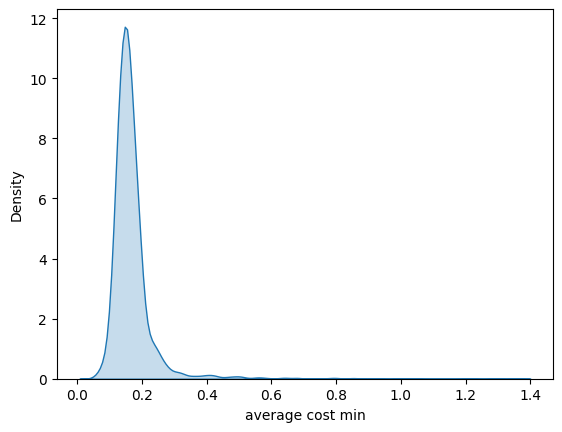

In [10]:
sns.kdeplot(data=train_data, x='average cost min', fill=True)

In [41]:
top_profitability_threshold = train_data['average cost min'].quantile(0.9)

In [42]:
top_profitability_threshold

0.2147121

In [ ]:
top_10_percent_data = train_data[train_data['average cost min'] > top_profitability_threshold]

In [44]:
X = top_10_percent_data.drop(columns=TARGET_VAR)
y = top_10_percent_data[TARGET_VAR] 

# These two probably doesn't need to be re-defined
NUM_VARS = top_10_percent_data.select_dtypes(include='number').drop(columns=TARGET_VAR).columns
CAT_VARS = top_10_percent_data.select_dtypes(include='object').columns

In [45]:
X_preprocessed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test= train_test_split(X_preprocessed, y, test_size=0.2, stratify=y, random_state=420)